In [31]:
%cd ..

/mnt/d/CodingProjects/zodiacal-polarized


In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from tqdm import  tqdm

from zodipol.mie_scattering.particle_size_model import ParticleSizeModel
from zodipol.mie_scattering.mie_scattering_model import MieScatteringModel
from zodipol.visualization.mie_plotting import plot_mueller_matrix_elems

In [49]:
# Kelsall's Model for comparision
from zodipy._source_funcs import get_phase_function

wavelength = 1250  # in nm
C1 = (-0.942, 0.121, -0.165)

In [50]:
def distance_from_kelsall(theta, func):
    kelsall_125um = get_phase_function(theta, C1)
    bhat = bhat_distance(theta, func, kelsall_125um)
    return bhat

def bhat_distance(theta, func1, func2):
    bhat_distance = -np.log(2*np.pi*np.trapz(np.sqrt(func1 * func2) * np.sin(theta), theta))
    return bhat_distance

In [51]:
spectrum = np.logspace(np.log10(300), np.log10(25000), 10)  # white light wavelength in nm
theta = np.linspace(0, np.pi, 100)  # angle in radians

# create a parameter mapping
s_min = np.logspace(np.log10(0.001), np.log10(1), 5)  # in um
s_max = np.logspace(np.log10(20), np.log10(100), 5)  # in um
big_gamma = np.arange(5.2, 5.6, 0.2)
small_gamma = np.arange(3.5, 4.5, 0.5)
BG, SG, SN, SX = np.meshgrid(big_gamma, small_gamma, s_min, s_max)  # create a grid of parameters
SN, SX, BG, SG = SN.flatten(), SX.flatten(), BG.flatten(), SG.flatten()  # flatten the grid

In [52]:
parameter_mapping = pd.DataFrame({'s_min': SN, 's_max': SX, 'big_gamma': BG, 'small_gamma': SG})  # create a dataframe from the grid
print(f'Number of models to train: {len(parameter_mapping)}')
parameter_mapping  # show the dataframe

Number of models to train: 100


,s_min,s_max,big_gamma,small_gamma
0,0.001,20.000000,5.2,3.5
1,0.001,29.906976,5.2,3.5
2,0.001,44.721360,5.2,3.5
3,0.001,66.874030,5.2,3.5
4,0.001,100.000000,5.2,3.5
...,...,...,...,...
95,1.000,20.000000,5.4,4.0
96,1.000,29.906976,5.4,4.0
97,1.000,44.721360,5.4,4.0
98,1.000,66.874030,5.4,4.0


In [69]:
results = []
for ind, row in tqdm(parameter_mapping.iterrows(), total=len(parameter_mapping)):
    # create a Mie scattering model
    psm = ParticleSizeModel(s_min=row['s_min'], s_max=row['s_max'], big_gamma=row['big_gamma'],
                            small_gamma=row['small_gamma'])  # create a particle size model
    mie = MieScatteringModel.train(spectrum, particle_size=psm)  # train a Mie scattering model

    # plot the model
    mueller_125um = mie.get_mueller_matrix(1250, theta)  # get the scattering
    mie_phase_func_125um = mueller_125um[..., 0, 0, 0]
    dist_from_kesall = distance_from_kelsall(theta, mie_phase_func_125um)

    mueller_spec = mie.get_mueller_matrix(np.array((spectrum.min(), spectrum.max())), theta)  # get the scattering
    mie_phase_func_spec = mueller_spec[..., 0, 0]
    dist_between_spec = bhat_distance(theta, mie_phase_func_spec[..., 0], mie_phase_func_spec[..., -1])

    row_dict = row.to_dict()
    row_dict['dist_from_kesall'] = dist_from_kesall
    row_dict['dist_between_spec'] = dist_between_spec

    print(row_dict)
    results.append(row_dict)

  1%|          | 1/100 [02:00<3:18:19, 120.20s/it]

{'s_min': 0.001, 's_max': 20.000000000000004, 'big_gamma': 5.2, 'small_gamma': 3.5, 'dist_from_kesall': 0.00630450337507518, 'dist_between_spec': 0.0014151301637161905}


  2%|▏         | 2/100 [04:06<3:22:33, 124.02s/it]

{'s_min': 0.001, 's_max': 29.906975624424415, 'big_gamma': 5.2, 'small_gamma': 3.5, 'dist_from_kesall': 0.00630932435067072, 'dist_between_spec': 0.0007644861797893673}


  3%|▎         | 3/100 [06:15<3:23:58, 126.17s/it]

{'s_min': 0.001, 's_max': 44.721359549995796, 'big_gamma': 5.2, 'small_gamma': 3.5, 'dist_from_kesall': 0.006308805749987476, 'dist_between_spec': 0.0006994714629069426}


  4%|▍         | 4/100 [08:27<3:25:37, 128.51s/it]

{'s_min': 0.001, 's_max': 66.87403049764221, 'big_gamma': 5.2, 'small_gamma': 3.5, 'dist_from_kesall': 0.006309849864296936, 'dist_between_spec': 0.0006669117058244948}


  5%|▌         | 5/100 [09:44<2:53:49, 109.78s/it]

{'s_min': 0.001, 's_max': 100.0, 'big_gamma': 5.2, 'small_gamma': 3.5, 'dist_from_kesall': 0.006309905372046482, 'dist_between_spec': 0.0006611382056909294}


  6%|▌         | 6/100 [10:47<2:27:26, 94.11s/it] 

{'s_min': 0.005623413251903491, 's_max': 20.000000000000004, 'big_gamma': 5.2, 'small_gamma': 3.5, 'dist_from_kesall': 0.0078104305637361655, 'dist_between_spec': 0.003056566155572539}


  7%|▋         | 7/100 [11:52<2:10:40, 84.30s/it]

{'s_min': 0.005623413251903491, 's_max': 29.906975624424415, 'big_gamma': 5.2, 'small_gamma': 3.5, 'dist_from_kesall': 0.007816391671876982, 'dist_between_spec': 0.002006795988305127}


  8%|▊         | 8/100 [12:57<2:00:16, 78.44s/it]

{'s_min': 0.005623413251903491, 's_max': 44.721359549995796, 'big_gamma': 5.2, 'small_gamma': 3.5, 'dist_from_kesall': 0.007815765778878837, 'dist_between_spec': 0.0019037836870929702}


  9%|▉         | 9/100 [14:06<1:54:20, 75.38s/it]

{'s_min': 0.005623413251903491, 's_max': 66.87403049764221, 'big_gamma': 5.2, 'small_gamma': 3.5, 'dist_from_kesall': 0.007814308326164096, 'dist_between_spec': 0.0018514349965659718}


 10%|█         | 10/100 [15:17<1:50:47, 73.86s/it]

{'s_min': 0.005623413251903491, 's_max': 100.0, 'big_gamma': 5.2, 'small_gamma': 3.5, 'dist_from_kesall': 0.007813827181763619, 'dist_between_spec': 0.0018415625133250291}


 11%|█         | 11/100 [16:25<1:47:07, 72.22s/it]

{'s_min': 0.03162277660168379, 's_max': 20.000000000000004, 'big_gamma': 5.2, 'small_gamma': 3.5, 'dist_from_kesall': 0.01334444373762425, 'dist_between_spec': 0.016774657147465535}


 12%|█▏        | 12/100 [17:39<1:46:36, 72.68s/it]

{'s_min': 0.03162277660168379, 's_max': 29.906975624424415, 'big_gamma': 5.2, 'small_gamma': 3.5, 'dist_from_kesall': 0.013348028452750712, 'dist_between_spec': 0.014088720374058951}


 13%|█▎        | 13/100 [18:55<1:46:50, 73.68s/it]

{'s_min': 0.03162277660168379, 's_max': 44.721359549995796, 'big_gamma': 5.2, 'small_gamma': 3.5, 'dist_from_kesall': 0.013346272318609343, 'dist_between_spec': 0.01381681186805248}


 14%|█▍        | 14/100 [20:12<1:47:01, 74.67s/it]

{'s_min': 0.03162277660168379, 's_max': 66.87403049764221, 'big_gamma': 5.2, 'small_gamma': 3.5, 'dist_from_kesall': 0.01334238060110353, 'dist_between_spec': 0.013659658838186976}


 15%|█▌        | 15/100 [21:29<1:46:53, 75.45s/it]

{'s_min': 0.03162277660168379, 's_max': 100.0, 'big_gamma': 5.2, 'small_gamma': 3.5, 'dist_from_kesall': 0.013339341040566919, 'dist_between_spec': 0.013627484871169082}


 16%|█▌        | 16/100 [22:51<1:48:12, 77.29s/it]

{'s_min': 0.1778279410038923, 's_max': 20.000000000000004, 'big_gamma': 5.2, 'small_gamma': 3.5, 'dist_from_kesall': 0.055758600937572386, 'dist_between_spec': 0.32916908884297574}


 17%|█▋        | 17/100 [24:18<1:51:02, 80.28s/it]

{'s_min': 0.1778279410038923, 's_max': 29.906975624424415, 'big_gamma': 5.2, 'small_gamma': 3.5, 'dist_from_kesall': 0.05573599231632522, 'dist_between_spec': 0.3109081050141873}


 18%|█▊        | 18/100 [25:45<1:52:34, 82.37s/it]

{'s_min': 0.1778279410038923, 's_max': 44.721359549995796, 'big_gamma': 5.2, 'small_gamma': 3.5, 'dist_from_kesall': 0.05569473912551794, 'dist_between_spec': 0.308536559218265}


 19%|█▉        | 19/100 [27:11<1:52:38, 83.44s/it]

{'s_min': 0.1778279410038923, 's_max': 66.87403049764221, 'big_gamma': 5.2, 'small_gamma': 3.5, 'dist_from_kesall': 0.0556397554128727, 'dist_between_spec': 0.30721601757407896}


 20%|██        | 20/100 [28:37<1:52:18, 84.23s/it]

{'s_min': 0.1778279410038923, 's_max': 100.0, 'big_gamma': 5.2, 'small_gamma': 3.5, 'dist_from_kesall': 0.055592511204045715, 'dist_between_spec': 0.30672336299657105}


 21%|██        | 21/100 [30:11<1:54:40, 87.10s/it]

{'s_min': 1.0, 's_max': 20.000000000000004, 'big_gamma': 5.2, 'small_gamma': 3.5, 'dist_from_kesall': 0.6108047486407477, 'dist_between_spec': 1.4234838636378757}


 22%|██▏       | 22/100 [31:48<1:57:04, 90.06s/it]

{'s_min': 1.0, 's_max': 29.906975624424415, 'big_gamma': 5.2, 'small_gamma': 3.5, 'dist_from_kesall': 0.6112688849670713, 'dist_between_spec': 1.3779229637143746}


 23%|██▎       | 23/100 [33:24<1:57:53, 91.87s/it]

{'s_min': 1.0, 's_max': 44.721359549995796, 'big_gamma': 5.2, 'small_gamma': 3.5, 'dist_from_kesall': 0.6111603602123683, 'dist_between_spec': 1.368174369694268}


 24%|██▍       | 24/100 [35:01<1:58:09, 93.29s/it]

{'s_min': 1.0, 's_max': 66.87403049764221, 'big_gamma': 5.2, 'small_gamma': 3.5, 'dist_from_kesall': 0.6108825396163832, 'dist_between_spec': 1.3635031307321854}


 25%|██▌       | 25/100 [36:34<1:56:50, 93.47s/it]

{'s_min': 1.0, 's_max': 100.0, 'big_gamma': 5.2, 'small_gamma': 3.5, 'dist_from_kesall': 0.6105220127845976, 'dist_between_spec': 1.3616716493944643}


 26%|██▌       | 26/100 [37:34<1:42:41, 83.26s/it]

{'s_min': 0.001, 's_max': 20.000000000000004, 'big_gamma': 5.4, 'small_gamma': 3.5, 'dist_from_kesall': 0.00630450337507518, 'dist_between_spec': 0.0014151301637161905}


 27%|██▋       | 27/100 [38:36<1:33:44, 77.05s/it]

{'s_min': 0.001, 's_max': 29.906975624424415, 'big_gamma': 5.4, 'small_gamma': 3.5, 'dist_from_kesall': 0.006309178244420631, 'dist_between_spec': 0.0007813763267050705}


 28%|██▊       | 28/100 [39:43<1:28:37, 73.85s/it]

{'s_min': 0.001, 's_max': 44.721359549995796, 'big_gamma': 5.4, 'small_gamma': 3.5, 'dist_from_kesall': 0.006308528986970594, 'dist_between_spec': 0.0007232205727912986}


 29%|██▉       | 29/100 [40:49<1:24:47, 71.66s/it]

{'s_min': 0.001, 's_max': 66.87403049764221, 'big_gamma': 5.4, 'small_gamma': 3.5, 'dist_from_kesall': 0.00630952170473604, 'dist_between_spec': 0.0006958701020310717}


 30%|███       | 30/100 [41:56<1:21:48, 70.12s/it]

{'s_min': 0.001, 's_max': 100.0, 'big_gamma': 5.4, 'small_gamma': 3.5, 'dist_from_kesall': 0.00630956630557326, 'dist_between_spec': 0.0006914114861969285}


 31%|███       | 31/100 [42:59<1:18:08, 67.95s/it]

{'s_min': 0.005623413251903491, 's_max': 20.000000000000004, 'big_gamma': 5.4, 'small_gamma': 3.5, 'dist_from_kesall': 0.0078104305637361655, 'dist_between_spec': 0.003056566155572539}


 32%|███▏      | 32/100 [44:06<1:16:41, 67.67s/it]

{'s_min': 0.005623413251903491, 's_max': 29.906975624424415, 'big_gamma': 5.4, 'small_gamma': 3.5, 'dist_from_kesall': 0.007816217358746871, 'dist_between_spec': 0.0020349299200057356}


 33%|███▎      | 33/100 [45:14<1:15:49, 67.90s/it]

{'s_min': 0.005623413251903491, 's_max': 44.721359549995796, 'big_gamma': 5.4, 'small_gamma': 3.5, 'dist_from_kesall': 0.007815430058789355, 'dist_between_spec': 0.0019433421466488186}


 34%|███▍      | 34/100 [46:26<1:15:50, 68.95s/it]

{'s_min': 0.005623413251903491, 's_max': 66.87403049764221, 'big_gamma': 5.4, 'small_gamma': 3.5, 'dist_from_kesall': 0.007813915131960513, 'dist_between_spec': 0.0018999979144912612}


 35%|███▌      | 35/100 [47:38<1:15:47, 69.97s/it]

{'s_min': 0.005623413251903491, 's_max': 100.0, 'big_gamma': 5.4, 'small_gamma': 3.5, 'dist_from_kesall': 0.007813421353980693, 'dist_between_spec': 0.001892131127575918}


 36%|███▌      | 36/100 [48:49<1:15:06, 70.41s/it]

{'s_min': 0.03162277660168379, 's_max': 20.000000000000004, 'big_gamma': 5.4, 'small_gamma': 3.5, 'dist_from_kesall': 0.01334444373762425, 'dist_between_spec': 0.016774657147465535}


 37%|███▋      | 37/100 [50:04<1:15:08, 71.56s/it]

{'s_min': 0.03162277660168379, 's_max': 29.906975624424415, 'big_gamma': 5.4, 'small_gamma': 3.5, 'dist_from_kesall': 0.013347753762507344, 'dist_between_spec': 0.014163629444665798}


 38%|███▊      | 38/100 [51:21<1:15:37, 73.19s/it]

{'s_min': 0.03162277660168379, 's_max': 44.721359549995796, 'big_gamma': 5.4, 'small_gamma': 3.5, 'dist_from_kesall': 0.013345740297138696, 'dist_between_spec': 0.013921721212117627}


 39%|███▉      | 39/100 [52:39<1:15:54, 74.66s/it]

{'s_min': 0.03162277660168379, 's_max': 66.87403049764221, 'big_gamma': 5.4, 'small_gamma': 3.5, 'dist_from_kesall': 0.013341754782487314, 'dist_between_spec': 0.01378864419839313}


 40%|████      | 40/100 [53:56<1:15:25, 75.42s/it]

{'s_min': 0.03162277660168379, 's_max': 100.0, 'big_gamma': 5.4, 'small_gamma': 3.5, 'dist_from_kesall': 0.013338693661910315, 'dist_between_spec': 0.013761485230257551}


 41%|████      | 41/100 [55:18<1:16:09, 77.44s/it]

{'s_min': 0.1778279410038923, 's_max': 20.000000000000004, 'big_gamma': 5.4, 'small_gamma': 3.5, 'dist_from_kesall': 0.055758600937572386, 'dist_between_spec': 0.32916908884297574}


 42%|████▏     | 42/100 [56:43<1:17:06, 79.77s/it]

{'s_min': 0.1778279410038923, 's_max': 29.906975624424415, 'big_gamma': 5.4, 'small_gamma': 3.5, 'dist_from_kesall': 0.05573506600003216, 'dist_between_spec': 0.31143375246165816}


 43%|████▎     | 43/100 [58:10<1:17:48, 81.90s/it]

{'s_min': 0.1778279410038923, 's_max': 44.721359549995796, 'big_gamma': 5.4, 'small_gamma': 3.5, 'dist_from_kesall': 0.055692940724634196, 'dist_between_spec': 0.3093053880731591}


 44%|████▍     | 44/100 [59:37<1:17:43, 83.27s/it]

{'s_min': 0.1778279410038923, 's_max': 66.87403049764221, 'big_gamma': 5.4, 'small_gamma': 3.5, 'dist_from_kesall': 0.05563764425922546, 'dist_between_spec': 0.308164357192262}


 45%|████▌     | 45/100 [1:01:03<1:17:12, 84.23s/it]

{'s_min': 0.1778279410038923, 's_max': 100.0, 'big_gamma': 5.4, 'small_gamma': 3.5, 'dist_from_kesall': 0.05559032055809065, 'dist_between_spec': 0.30771017952492974}


 46%|████▌     | 46/100 [1:02:38<1:18:42, 87.45s/it]

{'s_min': 1.0, 's_max': 20.000000000000004, 'big_gamma': 5.4, 'small_gamma': 3.5, 'dist_from_kesall': 0.6108047486407477, 'dist_between_spec': 1.4234838636378757}


 47%|████▋     | 47/100 [1:04:16<1:20:01, 90.60s/it]

{'s_min': 1.0, 's_max': 29.906975624424415, 'big_gamma': 5.4, 'small_gamma': 3.5, 'dist_from_kesall': 0.61124289247439, 'dist_between_spec': 1.3793715733781544}


 48%|████▊     | 48/100 [1:05:59<1:21:43, 94.30s/it]

{'s_min': 1.0, 's_max': 44.721359549995796, 'big_gamma': 5.4, 'small_gamma': 3.5, 'dist_from_kesall': 0.6111094001781286, 'dist_between_spec': 1.3706716034349529}


 49%|████▉     | 49/100 [1:07:36<1:20:54, 95.18s/it]

{'s_min': 1.0, 's_max': 66.87403049764221, 'big_gamma': 5.4, 'small_gamma': 3.5, 'dist_from_kesall': 0.6108222753517387, 'dist_between_spec': 1.3667371040855871}


 50%|█████     | 50/100 [1:09:11<1:19:16, 95.13s/it]

{'s_min': 1.0, 's_max': 100.0, 'big_gamma': 5.4, 'small_gamma': 3.5, 'dist_from_kesall': 0.6104594869427657, 'dist_between_spec': 1.365235293793645}


 51%|█████     | 51/100 [1:10:19<1:10:59, 86.93s/it]

{'s_min': 0.001, 's_max': 20.000000000000004, 'big_gamma': 5.2, 'small_gamma': 4.0, 'dist_from_kesall': 0.0012129760718376115, 'dist_between_spec': 0.0006735437847485762}


 52%|█████▏    | 52/100 [1:11:27<1:05:06, 81.38s/it]

{'s_min': 0.001, 's_max': 29.906975624424415, 'big_gamma': 5.2, 'small_gamma': 4.0, 'dist_from_kesall': 0.0012130940944657467, 'dist_between_spec': 0.0006540282083235092}


 53%|█████▎    | 53/100 [1:12:37<1:00:55, 77.77s/it]

{'s_min': 0.001, 's_max': 44.721359549995796, 'big_gamma': 5.2, 'small_gamma': 4.0, 'dist_from_kesall': 0.0012133885442927091, 'dist_between_spec': 0.0006556733371517085}


 54%|█████▍    | 54/100 [1:13:48<58:01, 75.69s/it]  

{'s_min': 0.001, 's_max': 66.87403049764221, 'big_gamma': 5.2, 'small_gamma': 4.0, 'dist_from_kesall': 0.0012135064487464908, 'dist_between_spec': 0.0006533001457302494}


 55%|█████▌    | 55/100 [1:15:02<56:32, 75.38s/it]

{'s_min': 0.001, 's_max': 100.0, 'big_gamma': 5.2, 'small_gamma': 4.0, 'dist_from_kesall': 0.0012137564952079199, 'dist_between_spec': 0.0006530834300673013}


 56%|█████▌    | 56/100 [1:16:19<55:32, 75.73s/it]

{'s_min': 0.005623413251903491, 's_max': 20.000000000000004, 'big_gamma': 5.2, 'small_gamma': 4.0, 'dist_from_kesall': 0.0007420322643353763, 'dist_between_spec': 0.002263628357906398}


 57%|█████▋    | 57/100 [1:17:44<56:14, 78.49s/it]

{'s_min': 0.005623413251903491, 's_max': 29.906975624424415, 'big_gamma': 5.2, 'small_gamma': 4.0, 'dist_from_kesall': 0.0007420992679161045, 'dist_between_spec': 0.002206293137871296}


 58%|█████▊    | 58/100 [1:19:07<55:52, 79.82s/it]

{'s_min': 0.005623413251903491, 's_max': 44.721359549995796, 'big_gamma': 5.2, 'small_gamma': 4.0, 'dist_from_kesall': 0.0007422610092117575, 'dist_between_spec': 0.002207620926894817}


 59%|█████▉    | 59/100 [1:20:32<55:40, 81.48s/it]

{'s_min': 0.005623413251903491, 's_max': 66.87403049764221, 'big_gamma': 5.2, 'small_gamma': 4.0, 'dist_from_kesall': 0.0007424138225768558, 'dist_between_spec': 0.0022015139460933365}


 60%|██████    | 60/100 [1:22:00<55:42, 83.55s/it]

{'s_min': 0.005623413251903491, 's_max': 100.0, 'big_gamma': 5.2, 'small_gamma': 4.0, 'dist_from_kesall': 0.0007425157820874747, 'dist_between_spec': 0.0022000151535930346}


 61%|██████    | 61/100 [1:23:33<56:08, 86.36s/it]

{'s_min': 0.03162277660168379, 's_max': 20.000000000000004, 'big_gamma': 5.2, 'small_gamma': 4.0, 'dist_from_kesall': 0.0015007795885419659, 'dist_between_spec': 0.016527670183606832}


 62%|██████▏   | 62/100 [1:25:12<57:01, 90.03s/it]

{'s_min': 0.03162277660168379, 's_max': 29.906975624424415, 'big_gamma': 5.2, 'small_gamma': 4.0, 'dist_from_kesall': 0.0014994893903978622, 'dist_between_spec': 0.016254210290569976}


 63%|██████▎   | 63/100 [1:26:39<54:57, 89.13s/it]

{'s_min': 0.03162277660168379, 's_max': 44.721359549995796, 'big_gamma': 5.2, 'small_gamma': 4.0, 'dist_from_kesall': 0.001498240195923722, 'dist_between_spec': 0.016241028202675867}


 64%|██████▍   | 64/100 [1:28:01<52:07, 86.88s/it]

{'s_min': 0.03162277660168379, 's_max': 66.87403049764221, 'big_gamma': 5.2, 'small_gamma': 4.0, 'dist_from_kesall': 0.0014968520040037228, 'dist_between_spec': 0.016198019615889757}


 65%|██████▌   | 65/100 [1:29:36<52:16, 89.60s/it]

{'s_min': 0.03162277660168379, 's_max': 100.0, 'big_gamma': 5.2, 'small_gamma': 4.0, 'dist_from_kesall': 0.001495714910955888, 'dist_between_spec': 0.016181255362833172}


 66%|██████▌   | 66/100 [1:31:16<52:24, 92.50s/it]

{'s_min': 0.1778279410038923, 's_max': 20.000000000000004, 'big_gamma': 5.2, 'small_gamma': 4.0, 'dist_from_kesall': 0.02788570551988895, 'dist_between_spec': 0.3559692010954325}


 67%|██████▋   | 67/100 [1:32:43<50:05, 91.07s/it]

{'s_min': 0.1778279410038923, 's_max': 29.906975624424415, 'big_gamma': 5.2, 'small_gamma': 4.0, 'dist_from_kesall': 0.027848667575425732, 'dist_between_spec': 0.3519845943101003}


 68%|██████▊   | 68/100 [1:34:33<51:28, 96.52s/it]

{'s_min': 0.1778279410038923, 's_max': 44.721359549995796, 'big_gamma': 5.2, 'small_gamma': 4.0, 'dist_from_kesall': 0.02781140842126885, 'dist_between_spec': 0.35154442857690515}


 69%|██████▉   | 69/100 [1:36:18<51:10, 99.06s/it]

{'s_min': 0.1778279410038923, 's_max': 66.87403049764221, 'big_gamma': 5.2, 'small_gamma': 4.0, 'dist_from_kesall': 0.02776785366446286, 'dist_between_spec': 0.35097379996226097}


 70%|███████   | 70/100 [1:37:39<46:49, 93.65s/it]

{'s_min': 0.1778279410038923, 's_max': 100.0, 'big_gamma': 5.2, 'small_gamma': 4.0, 'dist_from_kesall': 0.027731457130311, 'dist_between_spec': 0.35060621769342276}


 71%|███████   | 71/100 [1:39:08<44:40, 92.42s/it]

{'s_min': 1.0, 's_max': 20.000000000000004, 'big_gamma': 5.2, 'small_gamma': 4.0, 'dist_from_kesall': 0.5412318605515928, 'dist_between_spec': 1.3875368827682035}


 72%|███████▏  | 72/100 [1:40:42<43:19, 92.83s/it]

{'s_min': 1.0, 's_max': 29.906975624424415, 'big_gamma': 5.2, 'small_gamma': 4.0, 'dist_from_kesall': 0.5411086020431457, 'dist_between_spec': 1.36936358096448}


 73%|███████▎  | 73/100 [1:42:26<43:16, 96.17s/it]

{'s_min': 1.0, 's_max': 44.721359549995796, 'big_gamma': 5.2, 'small_gamma': 4.0, 'dist_from_kesall': 0.5408563280895837, 'dist_between_spec': 1.3662842630807464}


 74%|███████▍  | 74/100 [1:44:09<42:33, 98.22s/it]

{'s_min': 1.0, 's_max': 66.87403049764221, 'big_gamma': 5.2, 'small_gamma': 4.0, 'dist_from_kesall': 0.5405704275234895, 'dist_between_spec': 1.3641902386343474}


 75%|███████▌  | 75/100 [1:45:53<41:35, 99.81s/it]

{'s_min': 1.0, 's_max': 100.0, 'big_gamma': 5.2, 'small_gamma': 4.0, 'dist_from_kesall': 0.540255852784064, 'dist_between_spec': 1.3632859788844027}


 76%|███████▌  | 76/100 [1:46:52<35:03, 87.63s/it]

{'s_min': 0.001, 's_max': 20.000000000000004, 'big_gamma': 5.4, 'small_gamma': 4.0, 'dist_from_kesall': 0.0012129760718376115, 'dist_between_spec': 0.0006735437847485762}


 77%|███████▋  | 77/100 [1:47:55<30:49, 80.40s/it]

{'s_min': 0.001, 's_max': 29.906975624424415, 'big_gamma': 5.4, 'small_gamma': 4.0, 'dist_from_kesall': 0.0012130946907575938, 'dist_between_spec': 0.0006542893177655606}


 78%|███████▊  | 78/100 [1:49:06<28:21, 77.36s/it]

{'s_min': 0.001, 's_max': 44.721359549995796, 'big_gamma': 5.4, 'small_gamma': 4.0, 'dist_from_kesall': 0.0012133896257705674, 'dist_between_spec': 0.0006558037244596513}


 79%|███████▉  | 79/100 [1:50:12<25:53, 73.99s/it]

{'s_min': 0.001, 's_max': 66.87403049764221, 'big_gamma': 5.4, 'small_gamma': 4.0, 'dist_from_kesall': 0.0012135076888058793, 'dist_between_spec': 0.0006537623900535082}


 80%|████████  | 80/100 [1:51:20<24:08, 72.41s/it]

{'s_min': 0.001, 's_max': 100.0, 'big_gamma': 5.4, 'small_gamma': 4.0, 'dist_from_kesall': 0.0012137577343027746, 'dist_between_spec': 0.0006535579706228725}


 81%|████████  | 81/100 [1:52:30<22:39, 71.56s/it]

{'s_min': 0.005623413251903491, 's_max': 20.000000000000004, 'big_gamma': 5.4, 'small_gamma': 4.0, 'dist_from_kesall': 0.0007420322643353763, 'dist_between_spec': 0.002263628357906398}


 82%|████████▏ | 82/100 [1:53:39<21:12, 70.68s/it]

{'s_min': 0.005623413251903491, 's_max': 29.906975624424415, 'big_gamma': 5.4, 'small_gamma': 4.0, 'dist_from_kesall': 0.0007420996789225829, 'dist_between_spec': 0.002207234756245435}


 83%|████████▎ | 83/100 [1:54:48<19:55, 70.33s/it]

{'s_min': 0.005623413251903491, 's_max': 44.721359549995796, 'big_gamma': 5.4, 'small_gamma': 4.0, 'dist_from_kesall': 0.0007422617566300133, 'dist_between_spec': 0.0022083841409828316}


 84%|████████▍ | 84/100 [1:56:02<19:01, 71.35s/it]

{'s_min': 0.005623413251903491, 's_max': 66.87403049764221, 'big_gamma': 5.4, 'small_gamma': 4.0, 'dist_from_kesall': 0.0007424146330867293, 'dist_between_spec': 0.002203137308501761}


 85%|████████▌ | 85/100 [1:57:18<18:12, 72.84s/it]

{'s_min': 0.005623413251903491, 's_max': 100.0, 'big_gamma': 5.4, 'small_gamma': 4.0, 'dist_from_kesall': 0.0007425166343383813, 'dist_between_spec': 0.00220168549852694}


 86%|████████▌ | 86/100 [1:58:30<16:54, 72.49s/it]

{'s_min': 0.03162277660168379, 's_max': 20.000000000000004, 'big_gamma': 5.4, 'small_gamma': 4.0, 'dist_from_kesall': 0.0015007795885419659, 'dist_between_spec': 0.016527670183606832}


 87%|████████▋ | 87/100 [1:59:47<16:01, 73.96s/it]

{'s_min': 0.03162277660168379, 's_max': 29.906975624424415, 'big_gamma': 5.4, 'small_gamma': 4.0, 'dist_from_kesall': 0.0014994871065703247, 'dist_between_spec': 0.016259436225485768}


 88%|████████▊ | 88/100 [2:01:04<14:56, 74.74s/it]

{'s_min': 0.03162277660168379, 's_max': 44.721359549995796, 'big_gamma': 5.4, 'small_gamma': 4.0, 'dist_from_kesall': 0.0014982357172964198, 'dist_between_spec': 0.016246352129994358}


 89%|████████▉ | 89/100 [2:02:23<13:55, 75.95s/it]

{'s_min': 0.03162277660168379, 's_max': 66.87403049764221, 'big_gamma': 5.4, 'small_gamma': 4.0, 'dist_from_kesall': 0.0014968467079632243, 'dist_between_spec': 0.016206775566181594}


 90%|█████████ | 90/100 [2:03:43<12:52, 77.20s/it]

{'s_min': 0.03162277660168379, 's_max': 100.0, 'big_gamma': 5.4, 'small_gamma': 4.0, 'dist_from_kesall': 0.0014957094814626527, 'dist_between_spec': 0.01619030555299883}


 91%|█████████ | 91/100 [2:05:06<11:52, 79.13s/it]

{'s_min': 0.1778279410038923, 's_max': 20.000000000000004, 'big_gamma': 5.4, 'small_gamma': 4.0, 'dist_from_kesall': 0.02788570551988895, 'dist_between_spec': 0.3559692010954325}


 92%|█████████▏| 92/100 [2:06:32<10:47, 81.00s/it]

{'s_min': 0.1778279410038923, 's_max': 29.906975624424415, 'big_gamma': 5.4, 'small_gamma': 4.0, 'dist_from_kesall': 0.027848614680816702, 'dist_between_spec': 0.35207172399113906}


 93%|█████████▎| 93/100 [2:07:58<09:38, 82.63s/it]

{'s_min': 0.1778279410038923, 's_max': 44.721359549995796, 'big_gamma': 5.4, 'small_gamma': 4.0, 'dist_from_kesall': 0.027811306298484252, 'dist_between_spec': 0.35164871826667937}


 94%|█████████▍| 94/100 [2:09:27<08:26, 84.35s/it]

{'s_min': 0.1778279410038923, 's_max': 66.87403049764221, 'big_gamma': 5.4, 'small_gamma': 4.0, 'dist_from_kesall': 0.02776773435949549, 'dist_between_spec': 0.35111884624575007}


 95%|█████████▌| 95/100 [2:10:53<07:04, 84.94s/it]

{'s_min': 0.1778279410038923, 's_max': 100.0, 'big_gamma': 5.4, 'small_gamma': 4.0, 'dist_from_kesall': 0.027731333364719127, 'dist_between_spec': 0.3507564102589498}


 96%|█████████▌| 96/100 [2:12:30<05:54, 88.72s/it]

{'s_min': 1.0, 's_max': 20.000000000000004, 'big_gamma': 5.4, 'small_gamma': 4.0, 'dist_from_kesall': 0.5412318605515928, 'dist_between_spec': 1.3875368827682035}


 97%|█████████▋| 97/100 [2:14:08<04:34, 91.38s/it]

{'s_min': 1.0, 's_max': 29.906975624424415, 'big_gamma': 5.4, 'small_gamma': 4.0, 'dist_from_kesall': 0.5411029762729884, 'dist_between_spec': 1.3699105992952345}


 98%|█████████▊| 98/100 [2:15:45<03:06, 93.09s/it]

{'s_min': 1.0, 's_max': 44.721359549995796, 'big_gamma': 5.4, 'small_gamma': 4.0, 'dist_from_kesall': 0.5408453514199593, 'dist_between_spec': 1.3671252582171185}


 99%|█████████▉| 99/100 [2:17:22<01:34, 94.37s/it]

{'s_min': 1.0, 's_max': 66.87403049764221, 'big_gamma': 5.4, 'small_gamma': 4.0, 'dist_from_kesall': 0.5405574697012742, 'dist_between_spec': 1.365287728211676}


100%|██████████| 100/100 [2:19:03<00:00, 83.44s/it]

{'s_min': 1.0, 's_max': 100.0, 'big_gamma': 5.4, 'small_gamma': 4.0, 'dist_from_kesall': 0.5402424165119631, 'dist_between_spec': 1.364485395288887}


In [72]:
results_df = pd.DataFrame(results)
results_df

,s_min,s_max,big_gamma,small_gamma,dist_from_kesall,dist_between_spec
0,0.001,20.000000,5.2,3.5,0.006305,0.001415
1,0.001,29.906976,5.2,3.5,0.006309,0.000764
2,0.001,44.721360,5.2,3.5,0.006309,0.000699
3,0.001,66.874030,5.2,3.5,0.006310,0.000667
4,0.001,100.000000,5.2,3.5,0.006310,0.000661
...,...,...,...,...,...,...
95,1.000,20.000000,5.4,4.0,0.541232,1.387537
96,1.000,29.906976,5.4,4.0,0.541103,1.369911
97,1.000,44.721360,5.4,4.0,0.540845,1.367125
98,1.000,66.874030,5.4,4.0,0.540557,1.365288


<Axes: xlabel='dist_from_kesall', ylabel='dist_between_spec'>

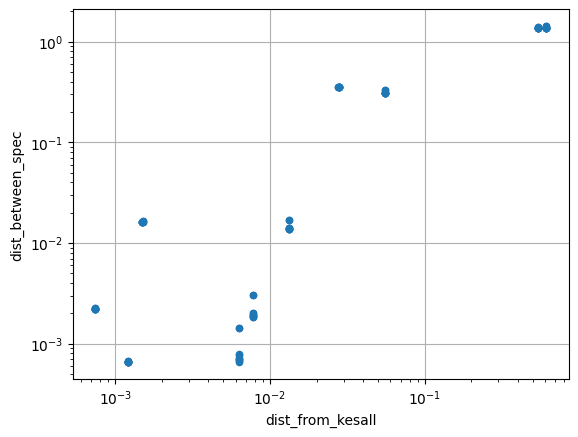

In [77]:
results_df.plot.scatter(x='dist_from_kesall', y='dist_between_spec', grid=True, loglog=True)

In [91]:
best_res = results_df.loc[results_df.dist_from_kesall.argmin()]
best_res

s_min                 0.005623
s_max                20.000000
big_gamma             5.200000
small_gamma           4.000000
dist_from_kesall      0.000742
dist_between_spec     0.002264
Name: 55, dtype: float64

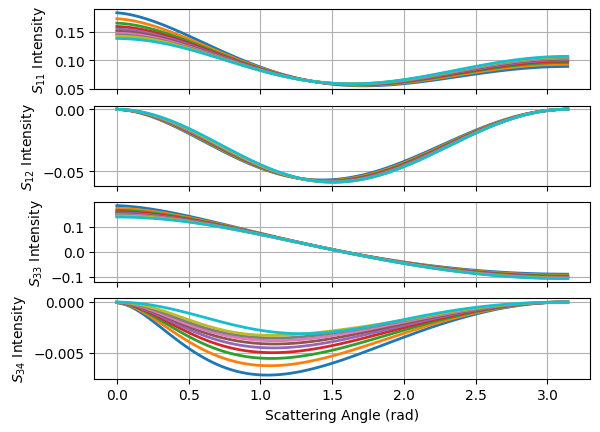

In [82]:
# recreate best results model and plot (full spectrum)
psm = ParticleSizeModel(s_min=best_res['s_min'], s_max=best_res['s_max'], big_gamma=best_res['big_gamma'], small_gamma=best_res['small_gamma'])  # create a particle size model
mie = MieScatteringModel.train(spectrum, particle_size=psm)
mie_scatt = mie(spectrum, theta)

# plot the Mueller matrix elements
plot_mueller_matrix_elems(theta, mie_scatt[:, :, 0, 0], mie_scatt[:, :, 0, 1],
                          mie_scatt[:, :, 2, 2], mie_scatt[:, :, 2, 3])

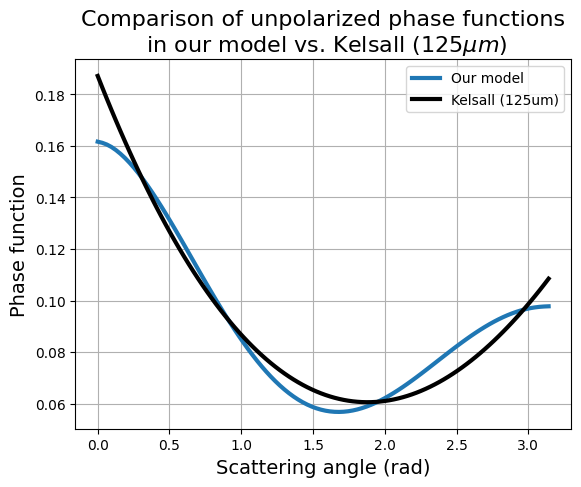

In [97]:
# Compare to Kelsall's model
mie_scatt = mie(1250, theta)
kelsall_125um = get_phase_function(theta, C1)

plt.figure()
plt.plot(theta, mie_scatt[:, :, 0, 0], lw=3, label='Our model')
plt.plot(theta, kelsall_125um, 'k', lw=3, label='Kelsall (125um)')
plt.title('Comparison of unpolarized phase functions\n in our model vs. Kelsall ($125\mu m$)', fontsize=16)
plt.xlabel('Scattering angle (rad)', fontsize=14)
plt.ylabel('Phase function', fontsize=14)
plt.grid()
plt.legend()
plt.show()

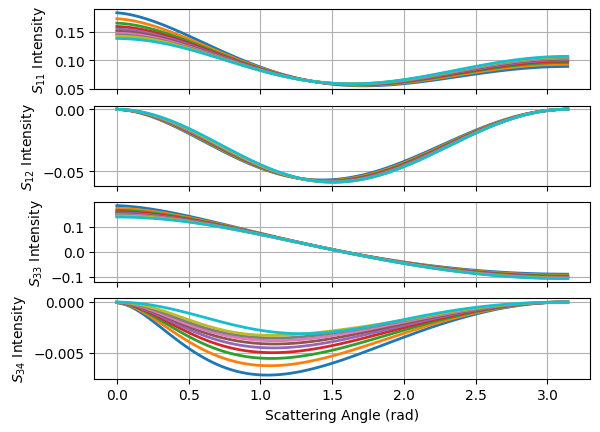

In [92]:
# Display out model in the White Light spectrum
spectrum_wl = np.logspace(np.log10(300), np.log10(25000), 10)  # white light wavelength in nm
psm = ParticleSizeModel(s_min=best_res['s_min'], s_max=best_res['s_max'], big_gamma=best_res['big_gamma'], small_gamma=best_res['small_gamma'])  # create a particle size model
mie = MieScatteringModel.train(spectrum_wl, particle_size=psm)
mie_scatt = mie(spectrum, theta)

# plot the Mueller matrix elements
plot_mueller_matrix_elems(theta, mie_scatt[:, :, 0, 0], mie_scatt[:, :, 0, 1],
                          mie_scatt[:, :, 2, 2], mie_scatt[:, :, 2, 3])

In [100]:
# save the new Mie model
from zodipol.zodipol.zodipol import MIE_MODEL_DEFAULT_PATH
mie.save(MIE_MODEL_DEFAULT_PATH)
print(MIE_MODEL_DEFAULT_PATH)

saved_models/white_light_mie_model.npz
